In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import json

In [26]:
courses = nx.read_graphml("courses.graphml")
students = json.load(open("students.json"))

In [ ]:
def get_gpa(grades):
    """Calculate GPA from a list of grades."""
    if not grades:
        return 0.0
    total_points = sum(grade* 3 for grade in grades)  # all grades are 3-credit hours
    return total_points / (3 * len(grades))

def get_open_courses(courses, student_courses):
    """Returns a list of open courses that a student can take."""
    open_courses = []
    for course_id in courses.nodes():
        if course_id in student_courses:
            continue 
        prerequisites = list(courses.predecessors(course_id))
        if all(prereq in student_courses for prereq in prerequisites):
            open_courses.append(course_id)
            
    return open_courses

In [28]:
students = students[:10]
Q = {}
alpha = 0.1
gamma = 0.9
gpa_history = {s['id'] : [round(s['gpa'], 1)] for s in students}
gpa_history

{'1': [1.9],
 '2': [2.5],
 '3': [2.5],
 '4': [2.1],
 '5': [2.3],
 '6': [2.9],
 '7': [1.8],
 '8': [2.0],
 '9': [2.2],
 '10': [1.3]}

In [31]:
def get_actions(open_courses, max_comb=100):
    actions = []
    for courses_cnt in range(3, 6):
        actions.extend(itertools.combinations(open_courses, courses_cnt))
    if len(actions) > max_comb:
        actions = random.sample(actions, max_comb)
    return actions

def take_courses(student, action):
    """Simulate taking courses and return the new GPA."""
    student_courses = student['courses']
    student_grades = student['grades']
    for course in action:
        grade = random.choice([0, 1, 2, 3, 4])
        student_grades.append({'id': course, 'grade': grade})
        if grade > 0:
            student_courses.append(course)
    
    new_gpa = get_gpa([grade['grade'] for grade in student_grades])
    
    return new_gpa, student_courses, student_grades

In [34]:
for episode in range(100):
    for student in students:
        state = (
            tuple(sorted(student['courses'])),
            round(student['gpa'], 1),
            student['semester']
        )
        open_courses = get_open_courses(courses, student['courses'])
        if len(open_courses) < 3: continue

        possible_actions = get_actions(open_courses)
        if not possible_actions : continue

        # explore or exploit

        if state not in Q:
            Q[state] = {action: 0 for action in possible_actions}   
            action = random.choice(possible_actions)
        else:
            if random.random() < 0.2:
                action = random.choice(possible_actions)
            else:
                action = max(Q[state], key=Q[state].get)
        # take action
        new_gpa, new_courses, new_grades = take_courses(student, action)
        # reward
        reward = new_gpa - student['gpa']

        # new state 
        new_state = (
            tuple(sorted(new_courses)),
            round(new_gpa, 1),
            student['semester'] + 1
        )
        # update Q-value
        max_new_q = max(Q.get(new_state, {}).values(), default=0)
        Q[state][action] += alpha * (reward + gamma * max_new_q - Q[state][action])
        # update student info
        student['gpa'] = new_gpa
        student['courses'] = new_courses
        student['grades'] = new_grades
        student['semester'] += 1
        gpa_history[student['id']].append(round(new_gpa, 1))

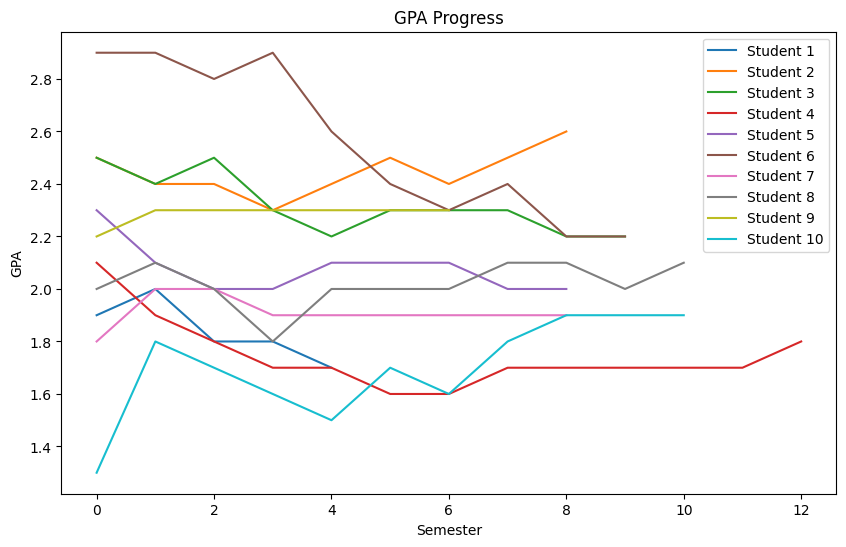

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for student_id, history in gpa_history.items():
    if int(student_id) <= 10:  # plot first 10 students
        plt.plot(history, label=f"Student {student_id}")

plt.xlabel("Semester")
plt.ylabel("GPA")
plt.title("GPA Progress")
plt.legend()
plt.show()